# 朴素神经网络的实现

## 将感知机应用于多分类任务

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Util import gen_five_clusters, visualize2d

class MultiPerceptron:
    def __init__(self):
        # 注意这里的 self._w 将来会是（n x K 的）矩阵
        self._w = None
        
    def fit(self, x, y, lr=1e-3, epoch=1000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        # x.shape[1] 即为 n、y.shape[1] 即为 K
        self._w = np.zeros([x.shape[1], y.shape[1]])
        for _ in range(epoch):
            # 依公式进行梯度下降
            y_pred = x.dot(self._w)
            dw = 2 * x.T.dot(y_pred - y)
            self._w -= lr * dw
    
    def predict(self, x):
        # 依公式计算模型输出向量
        y_pred = np.asarray(x, np.float32).dot(self._w)
        # 预测类别时对输出的 K 维向量用 argmax 即可
        return np.argmax(y_pred, axis=1).astype(np.float32)

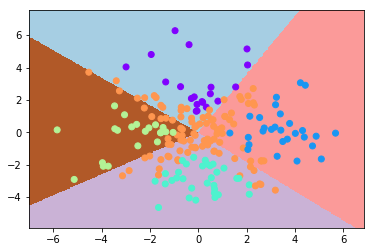

准确率：    50.5 %


In [2]:
x, y = gen_five_clusters()
label = np.argmax(y, axis=1)
perceptron = MultiPerceptron()
perceptron.fit(x, y)
visualize2d(perceptron, x, label, draw_background=True)
print("准确率：{:8.6} %".format((perceptron.predict(x) == label).mean() * 100))

## 从感知机到神经网络

In [3]:
class NaiveNN:
    def __init__(self, ws=None):
        # 这里的 self._ws 将会是一个存储着两个权值矩阵的列表
        self._ws = ws
        
    @staticmethod
    def relu(x):
        # 利用 numpy 相应函数直接写出 ReLU 的实现
        return np.maximum(0, x)
    
    # hidden_dim 即为隐藏层神经元个数 m
    def fit(self, x, y, hidden_dim=4, lr=1e-3, epoch=1000):
        input_dim, output_dim = x.shape[1], y.shape[1]
        if self._ws is None:
            # 随机初始化权值矩阵
            self._ws = [
                np.random.random([input_dim, hidden_dim]),
                np.random.random([hidden_dim, output_dim])
            ]
        # 定义一个列表存储训练过程中的损失
        losses = []
        for _ in range(epoch):
            # 依公式算出各个值
            h = x.dot(self._ws[0]); h_relu = NaiveNN.relu(h)
            y_pred = h_relu.dot(self._ws[1])
            # 利用 np.linalg.norm 算出损失
            losses.append(np.linalg.norm(y_pred - y, ord="fro"))
            # 依公式算出各个梯度
            d1 = 2 * (y_pred - y)
            dw2 = h_relu.T.dot(d1)
            dw1 = x.T.dot(d1.dot(self._ws[1].T) * (h_relu != 0))
            # 走一步梯度下降
            self._ws[0] -= lr * dw1; self._ws[1] -= lr * dw2
        # 把诸模型损失返回
        return losses
    
    def predict(self, x):
        h = x.dot(self._ws[0]); h_relu = NaiveNN.relu(h)
        # 用 argmax 预测类别
        return np.argmax(h_relu.dot(self._ws[1]), axis=1)

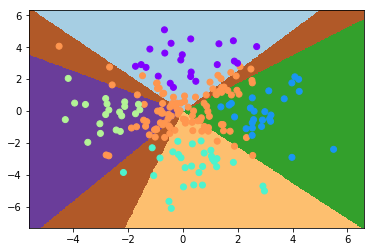

准确率：    56.5 %


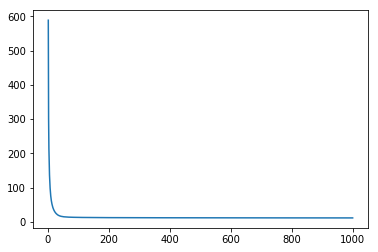

In [4]:
x, y = gen_five_clusters()
label = np.argmax(y, axis=1)
nn = NaiveNN()
losses = nn.fit(x, y, 32, 1e-5)
visualize2d(nn, x, label, draw_background=True)
print("准确率：{:8.6} %".format((nn.predict(x) == label).mean() * 100))

plt.figure()
plt.plot(np.arange(1, len(losses)+1), losses)
plt.show()

## 应用 Softmax + Cross Entropy

In [5]:
class NN:
    def __init__(self, ws=None):
        self._ws = ws
        
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    @staticmethod
    def cross_entropy(y_pred, y_true):
        return -np.average(
            y * np.log(np.maximum(y_pred, 1e-12)) +
            (1 - y) * np.log(np.maximum(1 - y_pred, 1e-12))
        )
    
    def fit(self, x, y, hidden_dim=4, lr=1e-3, epoch=1000):
        input_dim, output_dim = x.shape[1], y.shape[1]
        if self._ws is None:
            self._ws = [
                np.random.random([input_dim, hidden_dim]),
                np.random.random([hidden_dim, output_dim])
            ]
        losses = []
        for _ in range(epoch):
            h = x.dot(self._ws[0]); h_relu = NN.relu(h)
            y_pred = NN.softmax(h_relu.dot(self._ws[1]))
            losses.append(NN.cross_entropy(y_pred, y))
            d1 = y_pred - y
            dw2 = h_relu.T.dot(d1)
            dw1 = x.T.dot(d1.dot(self._ws[1].T) * (h_relu != 0))
            self._ws[0] -= lr * dw1; self._ws[1] -= lr * dw2
        return losses
    
    def predict(self, x):
        h = x.dot(self._ws[0]); h_relu = NaiveNN.relu(h)
        # 由于 Softmax 不影响 argmax 的结果，所以这里直接 argmax 即可
        return np.argmax(h_relu.dot(self._ws[1]), axis=1)

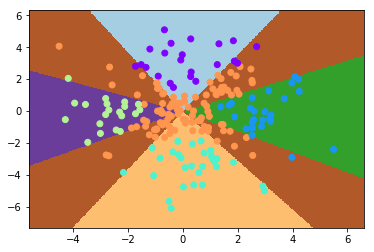

准确率：    77.5 %


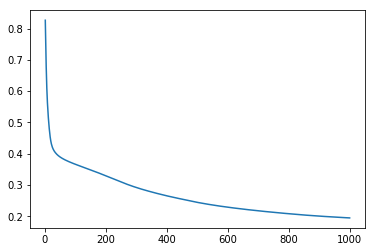

In [6]:
nn = NN()
losses = nn.fit(x, y, 32, 1e-4)
visualize2d(nn, x, label, draw_background=True)
print("准确率：{:8.6} %".format((nn.predict(x) == label).mean() * 100))

plt.figure()
plt.plot(np.arange(1, len(losses)+1), losses)
plt.show()